<a href="https://colab.research.google.com/github/Marcos-CT/Proyecto-Tifon/blob/feature%2Feda-marcos/modelo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title 🔀 Setup del proyecto usando una rama concreta
import sys, subprocess, shutil
from pathlib import Path

REPO_URL = "https://github.com/Marcos-CT/Proyecto-Tifon.git"
PROJECT_DIR = Path("/content/Proyecto-Tifon")
SRC_DIR = PROJECT_DIR / "src"
BRANCH = "feature/eda-marcos"  # ← PON AQUÍ TU RAMA

def run(cmd):
    print("➜", " ".join(cmd))
    return subprocess.run(cmd, check=False, text=True)

# 1) Clonar si hace falta
if PROJECT_DIR.exists() and not (PROJECT_DIR/".git").exists():
    shutil.rmtree(PROJECT_DIR, ignore_errors=True)
if not PROJECT_DIR.exists():
    run(["git", "clone", REPO_URL, str(PROJECT_DIR)])

# 2) Cambiar a la rama deseada
run(["git", "-C", str(PROJECT_DIR), "fetch", "origin", "--prune"])
# crea la rama local basada en la remota si no existe, o cámbiate si ya existe
run(["git", "-C", str(PROJECT_DIR), "checkout", "-B", BRANCH, f"origin/{BRANCH}"])
run(["git", "-C", str(PROJECT_DIR), "pull", "--ff-only"])

# 3) Instalar dependencias
req = PROJECT_DIR / "requirements.txt"
if req.exists():
    run([sys.executable, "-m", "pip", "install", "-q", "-r", str(req)])

# 4) Añadir src al path
if SRC_DIR.exists():
    sys.path.append(str(SRC_DIR))
    print("PYTHONPATH ✔", SRC_DIR)

# 5) Mostrar rama y último commit (para verificar)
run(["git", "-C", str(PROJECT_DIR), "rev-parse", "--abbrev-ref", "HEAD"])
run(["git", "-C", str(PROJECT_DIR), "log", "-1", "--oneline"])

print("✅ Proyecto listo en:", PROJECT_DIR)


➜ git clone https://github.com/Marcos-CT/Proyecto-Tifon.git /content/Proyecto-Tifon
➜ git -C /content/Proyecto-Tifon fetch origin --prune
➜ git -C /content/Proyecto-Tifon checkout -B feature/eda-marcos origin/feature/eda-marcos
➜ git -C /content/Proyecto-Tifon pull --ff-only
➜ /usr/bin/python3 -m pip install -q -r /content/Proyecto-Tifon/requirements.txt
PYTHONPATH ✔ /content/Proyecto-Tifon/src
➜ git -C /content/Proyecto-Tifon rev-parse --abbrev-ref HEAD
➜ git -C /content/Proyecto-Tifon log -1 --oneline
✅ Proyecto listo en: /content/Proyecto-Tifon


In [3]:
#----------------------------Importamos librerías----------------------------
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
#----------------------------Montamos drive y cargamos la base de datos----------------------------
drive.mount('/content/drive', force_remount=True)
DATA_DIR = "/content/drive/MyDrive/TIFON/"
df = pd.read_csv(f"{DATA_DIR}base_datos.csv")
print(df.shape)
display(df.head())
list(df.columns)

Mounted at /content/drive
(9999, 7)


,R,Fmax,a,N,SIF,x,y
0,0.0,62.491014,5.0,0.000000,174.730000,-20.000000,0.000000
1,0.0,62.491014,7.0,223713.790360,213.196004,-18.000000,0.000000
2,0.0,62.491014,9.0,344443.709373,243.796017,-16.000000,-0.000765
3,0.0,62.491014,11.0,424105.033144,267.816054,-14.000001,-0.002973
4,0.0,62.491014,13.0,483635.120072,299.968108,-12.000007,-0.007716


['R', 'Fmax', 'a', 'N', 'SIF', 'x', 'y']

In [5]:
#----------------------------Establecemos reproducibilidad----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [6]:
#----------------------------Preparamos los datos----------------------------
FEATURE_COLS = ["R", "Fmax", "a"]
TARGET_COLS = ["N", "SIF", "x", "y"]

X = df[FEATURE_COLS].to_numpy(dtype="float32")
Y = df[TARGET_COLS].to_numpy(dtype="float32")
assert X.shape[1] == 3, X.shape
assert Y.shape[1] == 4, Y.shape
print("X:", X.shape, "Y:", Y.shape)

X: (9999, 3) Y: (9999, 4)


In [7]:
#----------------------------Limpiamos y dividimos----------------------------
# Quita filas con no finitos
mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
X = X[mask]; Y = Y[mask]

# Imputación sencilla en X (por si hay NaN puntuales)
imputer = SimpleImputer(strategy="median")
X_clean = imputer.fit_transform(X).astype("float32")

# Split 80/20
X_tr, X_val, Y_tr, Y_val = train_test_split(X_clean, Y, test_size=0.2, random_state=SEED)
print("Train:", X_tr.shape, Y_tr.shape, "Val:", X_val.shape, Y_val.shape)

Train: (7999, 3) (7999, 4) Val: (2000, 3) (2000, 4)


In [8]:
#----------------------------Preprocesado----------------------------
scaler_X = StandardScaler()
X_tr_sc = scaler_X.fit_transform(X_tr).astype("float32")
X_val_sc = scaler_X.transform(X_val).astype("float32")

# --- transformar Y: log1p en y0,y1 y luego estandarizar TODAS las Y ---
def transform_targets_train(Y_tr):
    Yt = Y_tr.astype("float32").copy()
    # Cols en log (por escala/colas): y0 (idx 0) y y1 (idx 1)
    for j in (0, 1):
        Yt[:, j] = np.log1p(np.clip(Yt[:, j], a_min=0, a_max=None))
    scalerY = StandardScaler()
    Yt_sc = scalerY.fit_transform(Yt).astype("float32")
    return Yt_sc, scalerY

def transform_targets_val(Y_val, scalerY):
    Yv = Y_val.astype("float32").copy()
    for j in (0, 1):
        Yv[:, j] = np.log1p(np.clip(Yv[:, j], a_min=0, a_max=None))
    Yv_sc = scalerY.transform(Yv).astype("float32")
    return Yv_sc

Y_tr_sc, scaler_Y = transform_targets_train(Y_tr)
Y_val_sc = transform_targets_val(Y_val, scaler_Y)

# Guardamos límites robustos para invertir sin overflow (col-0 y col-1 en log)
def log_bounds_from_train(Y_tr):
    b = {}
    for j in (0, 1):
        yj = np.log1p(np.clip(Y_tr[:, j], a_min=0, a_max=None))
        lo = float(np.percentile(yj, 0))
        hi = float(np.percentile(yj, 99.9))
        max_orig = float(np.max(Y_tr[:, j]))
        b[j] = {"lo_log": lo, "hi_log": hi, "max_orig": max_orig}
    return b

Y_LOG_BOUNDS = log_bounds_from_train(Y_tr)
Y_LOG_BOUNDS

{0: {'lo_log': 0.0,
  'hi_log': 57.83488845825195,
  'max_orig': 1.3440726618904493e+25},
 1: {'lo_log': 7.27973529137671e-05,
  'hi_log': 6.281818389892578,
  'max_orig': 554.8944091796875}}

In [9]:
#----------------------------Función de inversa----------------------------
def inverse_transform_predictions_robust(Y_pred_sc, scalerY, log_cols=(0,1), bounds=Y_LOG_BOUNDS):
    """
    1) Desestandariza con scalerY.
    2) expm1 SOLO en columnas con log, clipando antes en log y después en original.
    Devuelve float64 para estabilidad numérica.
    """
    Y_tmp = scalerY.inverse_transform(np.asarray(Y_pred_sc)).astype(np.float64)

    for j in log_cols:
        lo_log = bounds[j]["lo_log"]; hi_log = bounds[j]["hi_log"]
        Y_tmp[:, j] = np.clip(Y_tmp[:, j], lo_log, hi_log)  # clip en log-space
        Y_tmp[:, j] = np.expm1(Y_tmp[:, j])                 # back a original
        Y_tmp[:, j] = np.clip(Y_tmp[:, j], 0.0, bounds[j]["max_orig"])  # no inventar > máx train

    return Y_tmp

In [10]:
#----------------------------Definimos el modelo----------------------------
# --- PASO 6: arquitectura ---
def build_mlp(output_dim=4, hidden=128, l2=5e-5, dropout=0.05, in_dim=None):
    """
    output_dim: nº de salidas del modelo (4 en nuestro problema de regresión multisalida)
    hidden: nº de neuronas en cada capa oculta (capacidad del modelo)
    l2: regularización L2 para contener sobreajuste (penaliza pesos grandes)
    dropout: fracción de neuronas que se apagan en entrenamiento (robustez)
    in_dim: dimensión de entrada; si es None, toma la de X_tr_sc
    """
    if in_dim is None:                    # si no se pasa explícitamente, detectamos el nº de features de X
        in_dim = X_tr_sc.shape[1]
    inputs = keras.Input(shape=(in_dim,)) # capa de entrada: vector con 'in_dim' características

    # Capa oculta 1: Dense con ReLU (no linealidad), inicializada con He (ideal para ReLU)
    x = layers.Dense(
        hidden, activation="relu",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(l2)
    )(inputs)

    # Dropout suave para mejorar generalización (apaga aleatoriamente 'dropout' fracción de activaciones)
    x = layers.Dropout(dropout)(x)

    # Capa oculta 2: repetimos patrón (más capacidad para capturar relaciones no lineales)
    x = layers.Dense(
        hidden, activation="relu",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(l2)
    )(x)

    # Capa de salida: 4 neuronas lineales (regresión; no aplicamos activación final)
    outputs = layers.Dense(output_dim, activation="linear")(x)

    # Ensamblamos el modelo funcional de Keras
    return keras.Model(inputs, outputs, name="MLP_3to4_regresion_clean")

# instanciamos el modelo con los hiperparámetros por defecto definidos arriba
model = build_mlp()
# mostramos un resumen de capas, formas y nº de parámetros
model.summary()


Model: "MLP_3to4_regresion_clean"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,540 (68.52 KB)

 Trainable params: 17,540 (68.52 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# --- Compilación ---

# Optimizador Adam:
# - learning_rate=3e-4: algo más bajo que el típico 1e-3 para un aprendizaje más estable
# - clipnorm=1.0: recorta la norma del gradiente si se dispara (evita explosiones numéricas)
opt = keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)

# Compilamos el modelo:
# - loss=Huber: pérdida robusta (menos sensible a outliers/colas que MSE)
# - metrics=["mae"]: métrica interpretable (error absoluto medio), en *escala transformada* de Y
model.compile(optimizer=opt, loss=keras.losses.Huber(delta=1.0), metrics=["mae"])

print("Compilado.")


Compilado.


Epoch 1/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3456 - mae: 0.6162 - val_loss: 0.1994 - val_mae: 0.3801 - learning_rate: 3.0000e-04
Epoch 2/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2231 - mae: 0.4375 - val_loss: 0.1951 - val_mae: 0.3635 - learning_rate: 3.0000e-04
Epoch 3/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2138 - mae: 0.4174 - val_loss: 0.1892 - val_mae: 0.3536 - learning_rate: 3.0000e-04
Epoch 4/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2058 - mae: 0.4017 - val_loss: 0.1851 - val_mae: 0.3461 - learning_rate: 3.0000e-04
Epoch 5/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2000 - mae: 0.3901 - val_loss: 0.1821 - val_mae: 0.3437 - learning_rate: 3.0000e-04
Epoch 6/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1960 - mae: 0.3821 - val_loss: 0.1795 - val_mae: 0.3387 - learning_rate: 3.0000e-04
Epoch 7/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1924 - mae: 0.3754 - val_loss: 0.1762 - val_mae: 0.3349

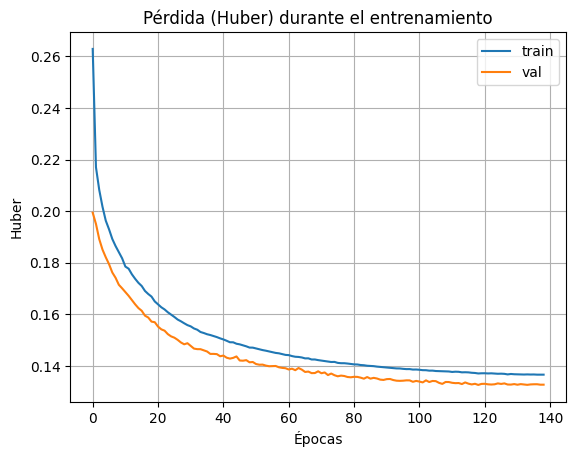

In [12]:
# --- Entrenamiento con callbacks ---

# EarlyStopping: si val_loss no mejora durante 'patience' épocas, detenemos
# y restauramos los mejores pesos (los que menor val_loss alcanzaron)
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

# ReduceLROnPlateau: si val_loss se estanca 'patience' épocas, reducimos el LR a la mitad
# (hasta min_lr) para permitir refinar el mínimo
plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1
)

# Entrenamiento propiamente dicho:
# - X_tr_sc / Y_tr_sc: datos de entrenamiento (X escalada; Y transformada + estandarizada)
# - validation_data: conjunto de validación para controlar generalización
# - epochs: máximo de épocas (EarlyStopping puede parar antes)
# - batch_size: tamaño del lote (32 es un buen compromiso)
# - callbacks: añadimos early stopping + reducción de LR automática
# - verbose=1: muestra el progreso por época
hist = model.fit(
    X_tr_sc, Y_tr_sc,
    validation_data=(X_val_sc, Y_val_sc),
    epochs=300,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

# Curva de pérdida: comparamos Huber en train vs val por época
plt.figure()
plt.plot(hist.history["loss"], label="train")       # pérdida en entrenamiento
plt.plot(hist.history["val_loss"], label="val")     # pérdida en validación
plt.xlabel("Épocas")
plt.ylabel("Huber")
plt.title("Pérdida (Huber) durante el entrenamiento")
plt.legend(); plt.grid(True); plt.show()


In [13]:
# --- Métricas ---

# 1) Obtenemos predicciones en escala *transformada* (tal y como entrena la red)
Y_hat_sc = model.predict(X_val_sc, verbose=0)

# 2) Para columnas en log (y0,y1):
#    desestandarizamos para llevarlas al espacio 'log' y medimos en log-space (RMSLE / R²_log)
Y_val_log = scaler_Y.inverse_transform(Y_val_sc.copy()).astype(np.float64)  # y_true en log-space para y0,y1
Y_hat_log = scaler_Y.inverse_transform(Y_hat_sc.copy()).astype(np.float64)  # y_pred en log-space para y0,y1

# aplicamos cortes prudentes en log para evitar extremos raros (percentil 99.9 de train)
for j in (0, 1):
    lo = Y_LOG_BOUNDS[j]["lo_log"]   # típicamente 0.0 tras log1p
    hi = Y_LOG_BOUNDS[j]["hi_log"]   # p99.9 en train
    Y_val_log[:, j] = np.clip(Y_val_log[:, j], lo, hi)
    Y_hat_log[:, j] = np.clip(Y_hat_log[:, j], lo, hi)

# Métricas en log-space para y0 e y1:
# - RMSLE: raíz del MSE en log (muy usada cuando hay escalas grandes y multiplicativas)
# - R²_log: coeficiente de determinación en el espacio log
rmsle_y0 = np.sqrt(mean_squared_error(Y_val_log[:, 0], Y_hat_log[:, 0]))
r2log_y0 = r2_score(Y_val_log[:, 0], Y_hat_log[:, 0])

rmsle_y1 = np.sqrt(mean_squared_error(Y_val_log[:, 1], Y_hat_log[:, 1]))
r2log_y1 = r2_score(Y_val_log[:, 1], Y_hat_log[:, 1])

# 3) Para y2,y3 (y, si quieres diagnosticar, y1 en original):
#    invertimos a escala *original* con una función robusta (clip en log y en original)
Y_hat = inverse_transform_predictions_robust(
    Y_hat_sc, scaler_Y,
    log_cols=(0, 1),               # indicamos que y0 e y1 están en log
    bounds=Y_LOG_BOUNDS            # límites robustos calculados en train
)

# Métricas clásicas en original para y2 e y3:
mae_y2  = mean_absolute_error(              Y_val[:, 2], Y_hat[:, 2])
rmse_y2 = np.sqrt(mean_squared_error(       Y_val[:, 2], Y_hat[:, 2]))
r2_y2   = r2_score(                         Y_val[:, 2], Y_hat[:, 2])

mae_y3  = mean_absolute_error(              Y_val[:, 3], Y_hat[:, 3])
rmse_y3 = np.sqrt(mean_squared_error(       Y_val[:, 3], Y_hat[:, 3]))
r2_y3   = r2_score(                         Y_val[:, 3], Y_hat[:, 3])

# Reporte compacto
print(f"y0 (log): RMSLE={rmsle_y0:.4f}  | R2_log={r2log_y0:.4f}")
print(f"y1 (log): RMSLE={rmsle_y1:.4f}  | R2_log={r2log_y1:.4f}")
print(f"y2 (orig): MAE={mae_y2:.4f}  RMSE={rmse_y2:.4f}  R2={r2_y2:.4f}")
print(f"y3 (orig): MAE={mae_y3:.4f}  RMSE={rmse_y3:.4f}  R2={r2_y3:.4f}")


y0 (log): RMSLE=8.3097  | R2_log=0.2646
y1 (log): RMSLE=1.5562  | R2_log=-0.0021
y2 (orig): MAE=0.1567  RMSE=0.1921  R2=0.9990
y3 (orig): MAE=0.0256  RMSE=0.0461  R2=0.9969


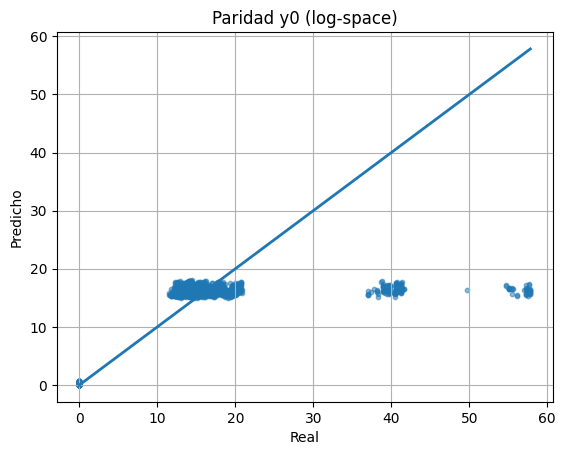

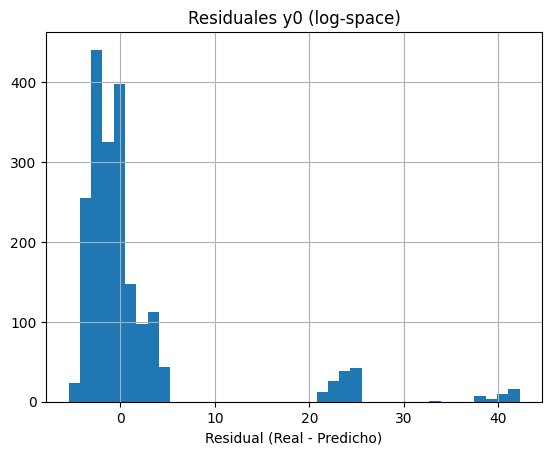

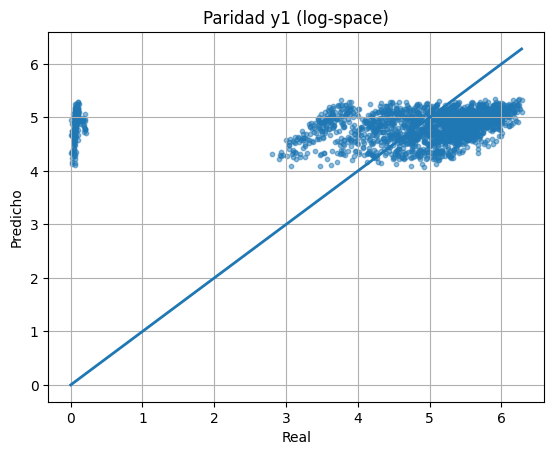

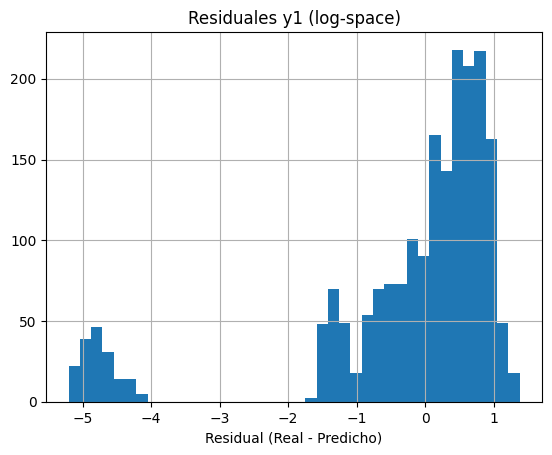

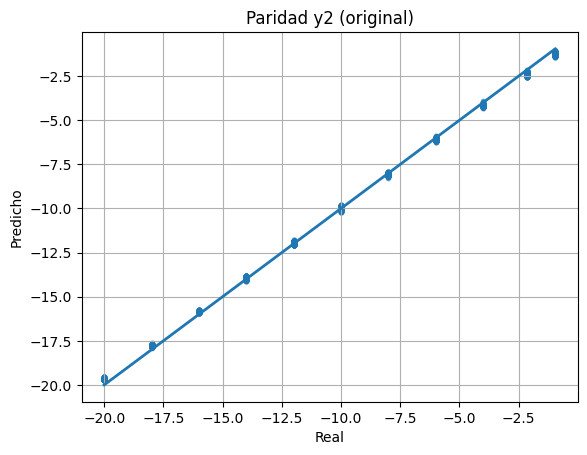

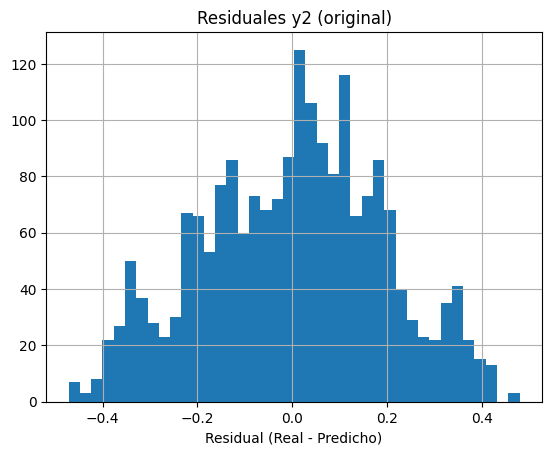

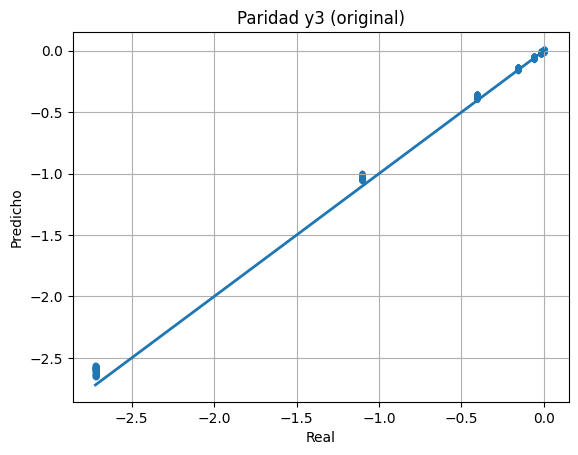

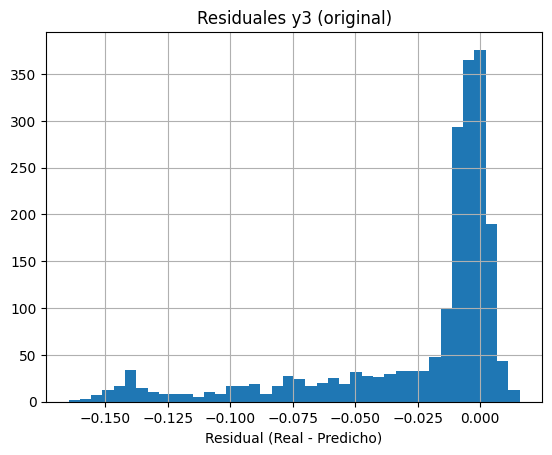

In [14]:
# --- Gráficas de diagnóstico ---

def parity(y_true, y_pred, title):
    """Dispersión Real vs Predicho + línea y=x para ver ajuste ideal."""
    lo = np.min([y_true.min(), y_pred.min()])
    hi = np.max([y_true.max(), y_pred.max()])
    plt.figure()
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lo, hi], [lo, hi], lw=2)
    plt.title(title); plt.xlabel("Real"); plt.ylabel("Predicho")
    plt.grid(True); plt.show()

def resid(y_true, y_pred, title):
    """Histograma de residuales (Real - Predicho) para ver sesgo/colas."""
    r = y_true - y_pred
    plt.figure()
    plt.hist(r, bins=40)
    plt.title(title); plt.xlabel("Residual (Real - Predicho)")
    plt.grid(True); plt.show()

# y0 e y1: evaluamos en log-space (coherente con el entrenamiento)
parity(Y_val_log[:, 0], Y_hat_log[:, 0], "Paridad y0 (log-space)")
resid( Y_val_log[:, 0], Y_hat_log[:, 0], "Residuales y0 (log-space)")

parity(Y_val_log[:, 1], Y_hat_log[:, 1], "Paridad y1 (log-space)")
resid( Y_val_log[:, 1], Y_hat_log[:, 1], "Residuales y1 (log-space)")

# y2 e y3: en escala original (tras invertir predicciones)
parity(Y_val[:, 2], Y_hat[:, 2], "Paridad y2 (original)")
resid( Y_val[:, 2], Y_hat[:, 2], "Residuales y2 (original)")

parity(Y_val[:, 3], Y_hat[:, 3], "Paridad y3 (original)")
resid( Y_val[:, 3], Y_hat[:, 3], "Residuales y3 (original)")
